In [1]:
%matplotlib notebook

# Specify CUDA device
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

# Parameters

In [12]:
sampling = "mw"
multiresolution = True
reality = True

L = 256
N = 2
J_min = 1

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=8 J_max=8


# Filters

<IPython.core.display.Javascript object>


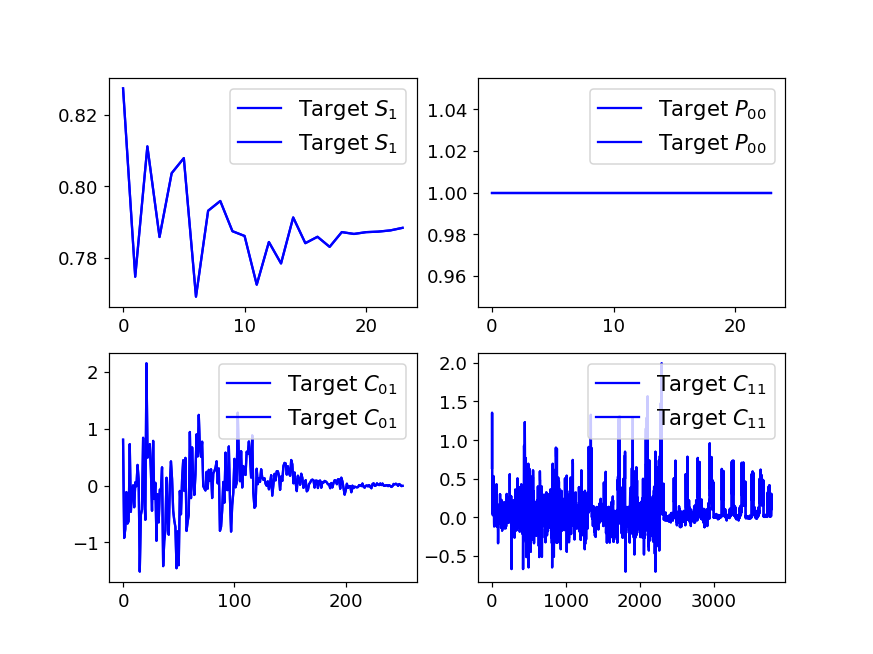

In [13]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

# Weights and precomps

In [14]:
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)


# Target map

In [15]:
### Sky
#f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=reality)
#print('Target = LSS map')

#f_target, flm_target = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
#print('Target = CMB map')

# f_target, flm_target = sphlib.make_planet(L, planet, normalize=True, reality=reality)
# print('Target = Planet map')

### Noise
np.random.seed(2)
pp = 1. ## Factor above CI
mu = 0.
if reality:  # Real map
    f_target = pp * np.random.randn(L, 2 * L - 1).astype(np.float64) + mu
else:
    f_target = pp * np.random.randn(L, 2 * L - 1).astype(np.float64) + pp*1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

flm_target = s2fft.forward_jax(f_target, L, reality=reality)

# Cut the flm
flm_target = flm_target[:, L - 1:] if reality else flm


In [16]:
print(np.mean(f_target), np.std(f_target))

-0.003015547470731016 1.000965402815674


In [17]:
#reload(scatlib)
#_, _, tS1, tP00, tC01, tC11 = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
 #                      reality, multiresolution, for_synthesis=True, normalisation=None,
  #                     filters=filters, quads=weights, precomps=precomps)

In [18]:
#plt.figure(figsize=(10, 10))
#plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='', hold=False, color='red')

In [19]:
reload(scatlib)
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target)

### P00 for normalisation
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, sampling, None,
                               reality, multiresolution, for_synthesis=False, normalisation=None,
                               filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

### Normalize the coeffs or not
norm = tP00_norm
print(norm)

### Scat coeffs S1, P00, C01, C11
# P00 is one because of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=norm,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays


 j2=1 Lj2=4

 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=128

 j2=7 Lj2=256

 j2=8 Lj2=256
[Array([7.41947363e-06, 7.13913528e-06, 8.62360311e-06], dtype=float64), Array([4.59624266e-05, 2.75240568e-05, 2.32674958e-05], dtype=float64), Array([0.00017619, 0.00019897, 0.00017059], dtype=float64), Array([0.00069036, 0.00070292, 0.00068263], dtype=float64), Array([0.00273757, 0.00268793, 0.00273335], dtype=float64), Array([0.0106114 , 0.01042652, 0.0103021 ], dtype=float64), Array([0.04171936, 0.0410728 , 0.04152621], dtype=float64), Array([0.04397888, 0.04355149, 0.0444412 ], dtype=float64)]

 j2=1 Lj2=4

 j2=2 Lj2=8

 j2=3 Lj2=16

 j2=4 Lj2=32

 j2=5 Lj2=64

 j2=6 Lj2=128

 j2=7 Lj2=256

 j2=8 Lj2=256


In [23]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=False, color='blue')

<IPython.core.display.Javascript object>


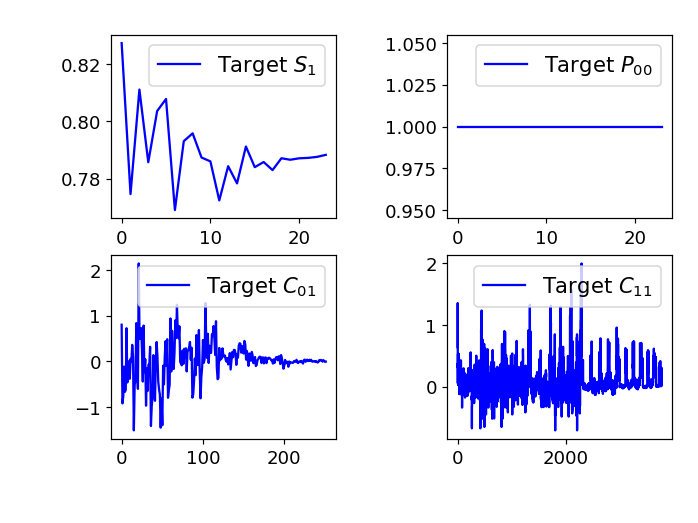

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.plot(np.arange(J_min, J_max+1), tP00_norm)
ax0.set_yscale('log')
ax0.set_ylim(1e-6, 1e-1)
ax0.set_ylabel('P00')
ax0.set_xlabel('j')
ax0.grid()


ax1.plot(ps_target)
ax1.set_yscale('log')
ax1.set_ylim(1e-6, 1e-1)
ax1.set_ylabel('Power spectrum')
ax1.set_xlabel(r'$\ell$')
ax1.grid()

fig.tight_layout()

In [10]:
# Plot the map
# mx, mn = np.nanmax(np.real(f_target)), np.nanmin(np.real(f_target))
# plot.plot_map_MW_Mollweide(np.real(f_target), figsize=(8, 6), vmin=mn, vmax=mx)

In [11]:
print(tP00)
print(norm)

[1. 1. 1. 1. 1. 1. 1. 1.]
[Array([1.03822082e-05], dtype=float64), Array([4.01822225e-05], dtype=float64), Array([0.00017779], dtype=float64), Array([0.00064469], dtype=float64), Array([0.00258504], dtype=float64), Array([0.01027616], dtype=float64), Array([0.04090874], dtype=float64), Array([0.04348307], dtype=float64)]


# Define the loss

In [12]:
#@jit
#def loss_func_ps_only(flm):
 #   ps = sphlib.compute_ps(flm)
  #  loss = synlib.chi2(ps_target, ps)
   # return loss
    
# @jit
# def loss_func_P00_only_complex(flm):
    
#     P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
#                           None, reality, multiresolution, for_synthesis=True,
#                           normalisation=tP00_norm, filters=filters,
#                           quads=weights, precomps=precomps)
#     loss = synlib.chi2(tP00, P00_new)
#     return loss

@jit
def loss_func_P00_only(flm_float):
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss


# @jit
# def loss_func(flm_float):
#     # Make complex flm
#     flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
#     mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, sampling,
#                                                                         None, reality, multiresolution,
#                                                                         for_synthesis=True,
#                                                                         normalisation=tP00_norm, filters=filters,
#                                                                         quads=weights, precomps=precomps)
#     # Control for mean + var
#     loss = synlib.chi2(tmean, mean_new)
#     loss += synlib.chi2(tvar, var_new)

#     # Add S1, P00, C01, C11 losses
#     loss += synlib.chi2(tS1, S1_new)
#     loss += synlib.chi2(tP00, P00_new)
#     loss += synlib.chi2(tC01, C01_new)
#     loss += synlib.chi2(tC11, C11_new)

#     return loss


# Initial condition

In [18]:
# Gaussian white noise in pixel space with the variance of the target
print(f'{tvar=}')
np.random.seed(42)
if reality:  # Real map
    f = np.sqrt(tvar) / pp * np.random.randn(L, 2 * L - 1).astype(np.float64)
else:
    f = np.sqrt(tvar) / pp * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

flm = s2fft.forward_jax(f, L, reality=reality)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

# Make a float array
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]

print('Starting loss', loss_func_P00_only(flm_float))
# print(scatlib.get_P00only(flm, L, N, J_min, sampling,
#                           None, reality, multiresolution, for_synthesis=True,
#                           normalisation=tP00_norm, filters=filters,
#                           quads=weights, precomps=precomps))

tvar=Array(0.61656327+0.j, dtype=complex128)
Starting loss 1.1115831742374012


In [19]:
tvar

Array(0.61656327+0.j, dtype=complex128)

<IPython.core.display.Javascript object>


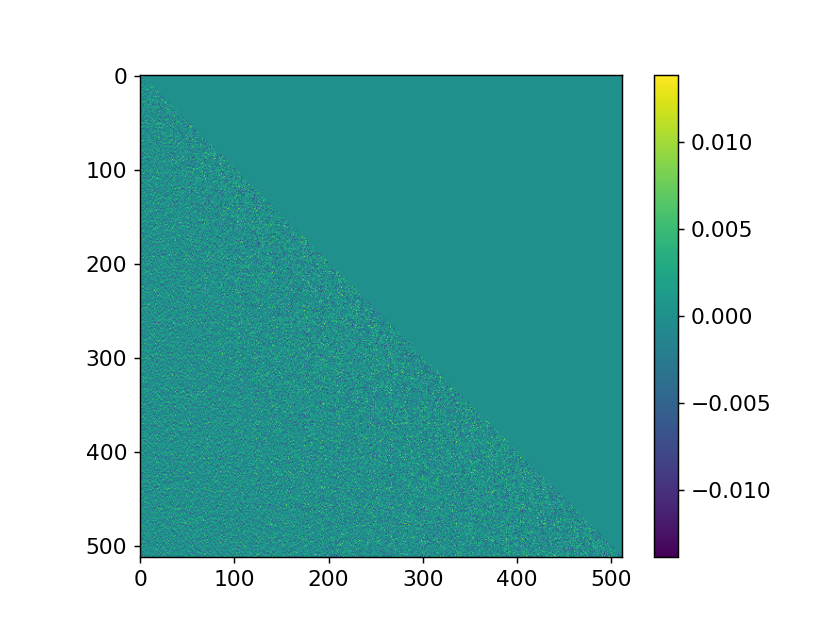

In [20]:
plt.figure()
plt.imshow(np.imag(flm))
plt.colorbar()

# Run the synthesis

### Gradient descent à la main : on veut pas faire ça nous même

- Si je ne mets pas le conjugué, ça diverge.
- Avec le conjugué, ça descend lentement et le PS et la carte ne changent pas bcp

In [16]:
# niter = 400
# momentum = 1
# flm, loss_history = synlib.fit_brutal(flm, loss_func_P00_only, momentum=momentum, niter=niter, loss_history=None)

# flm_end = jnp.copy(flm)

### Using Optax

- Avec Adam, ca converge bien et le PS et la carte ont l'air ok

In [25]:
# niter = 10
# lr = 1e-2
# #optimizer = optax.fromage(lr)
# optimizer = optax.adam(lr)
# #optimizer = optax.adagrad(lr)
# flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func_P00_only_complex, niter=niter, loss_history=None)

# flm_end = jnp.copy(flm)

### Using Jaxopt

- Methods : GradientDescent ou LBFGS
- Ne marche pas avec des complexes, c'est pour ça que la loss divergeait systématiquement.
- Avec LBFGS, il est bcp + lent que Jaxopt.scipy.minimize('LBFGS')

In [122]:
# flm, loss_history = synlib.fit_jaxopt(flm_float, loss_func_P00_only, method='GradientDescent', niter=300, loss_history=None)

# # flm_end = jnp.copy(flm)
# flm_end = flm[0, :, :] + 1j * flm[1, :, :]

### Using jaxopt Scipy

- Methods: CG, Newton-CG, L-BFGS-B
- Ca ne marche pas avec des complexes. Par défaut, il convertit les arrays en float 64. Résultat on a une carte output symmétrique parce que la partie Im des flm est mise à 0. 
- Si on itère sur les parties Re et Im ça marche. 

In [21]:
### P00 only
flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=500, loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 0.9836022856881863, Time = 35.3517572880 s/iter
Iter 10, Success: False, Loss = 0.5842374057721301, Time = 3.7715530396 s/iter
Iter 20, Success: False, Loss = 0.5316325222765639, Time = 3.3055615425 s/iter
Iter 30, Success: False, Loss = 0.43683380358758817, Time = 3.7993500233 s/iter
Iter 40, Success: False, Loss = 0.4160242617344095, Time = 3.8091349602 s/iter
Iter 50, Success: False, Loss = 0.3419119326407799, Time = 2.8369429111 s/iter
Iter 60, Success: False, Loss = 0.3316049554462809, Time = 3.7465820312 s/iter
Iter 70, Success: False, Loss = 0.23207915502464213, Time = 3.7402007580 s/iter
Iter 80, Success: False, Loss = 0.14924515446519782, Time = 3.3412756920 s/iter
Iter 90, Success: False, Loss = 0.09955074588049308, Time = 4.2297918797 s/iter
Iter 100, Success: False, Loss = 0.09608219030092062, Time = 3.7883467674 s/iter
Iter 110, Success: False, Loss = 0.08727361212516421, Time = 2.8261101246 s/iter
Iter 120, Success: False, Loss = 0.075345524

In [27]:
# ### All coeffs        
# flm, loss_history = synlib.fit_jaxopt_Scipy(flm_float, loss_func, method='L-BFGS-B', niter=600, loss_history=None)

# #flm_end = jnp.copy(flm)
# flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [28]:
# ### P00 and then all coeffs       
# flm, loss_historyP00 = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=300, loss_history=None)

# flm, loss_history = synlib.fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=loss_historyP00)

# #flm_end = jnp.copy(flm)
# flm_end = flm[0, :, :] + 1j * flm[1, :, :]


In [29]:
# plt.figure()
# plt.title('flm_end Im part')
# plt.imshow(np.imag(flm_end))
# plt.colorbar()

# Check the synthesis

In [22]:
# Coeffs

scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, sampling, None,
                           reality, multiresolution, for_synthesis=True, normalisation=norm,
                           filters=filters, quads=weights, precomps=precomps)
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=norm,
                       filters=filters, quads=weights, precomps=precomps)


tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [23]:
print(flm_target.shape, flm_start.shape, flm_end.shape)

(512, 512) (512, 512) (512, 512)


In [24]:
flm_target

Array([[-7.87856740e-03+0.j        ,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        , ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [-7.23651662e-05+0.j        , -1.49078695e-03+0.00202656j,
         0.00000000e+00+0.j        , ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 6.18136930e-03+0.j        , -1.23479108e-04-0.00365343j,
        -2.15352479e-04+0.00154091j, ...,  0.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       ...,
       [-2.52492261e-03+0.j        , -8.84881288e-04-0.00408457j,
         4.08297193e-03-0.00196843j, ...,  8.32465981e-03+0.00654609j,
         0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 4.45531260e-03+0.j        ,  4.28891437e-03+0.00474872j,
        -1.31030980e-03-0.00096522j, ...,  9.48421621e-04+0.00372347j,
         3.39405935e-03-0.00371973j

In [25]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

In [26]:
flm_target

Array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       ...,
       [-0.00252492+0.j        , -0.00088488-0.00408457j,
         0.00408297-0.00196843j, ...,  0.00832466+0.00654609j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.00445531+0.j        ,  0.00428891+0.00474872j,
        -0.00131031-0.00096522j, ...,  0.00094842+0.00372347j,
         0.00339406-0.00371973j,  0.        +0.j        ],
       [ 0.00739517+0.j        ,  0.00341337+0.00476704j,
        -0.00263672-0.00032106

In [27]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Mean and var

In [28]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

Mean: 0.002222502831366517 0.0009040928541535271 0.0009040928541535271
Var: (0.6165632699535422+0j) (0.38043089989654577+0j) (0.6161623874560597+0j)


### Plot the loss

<IPython.core.display.Javascript object>


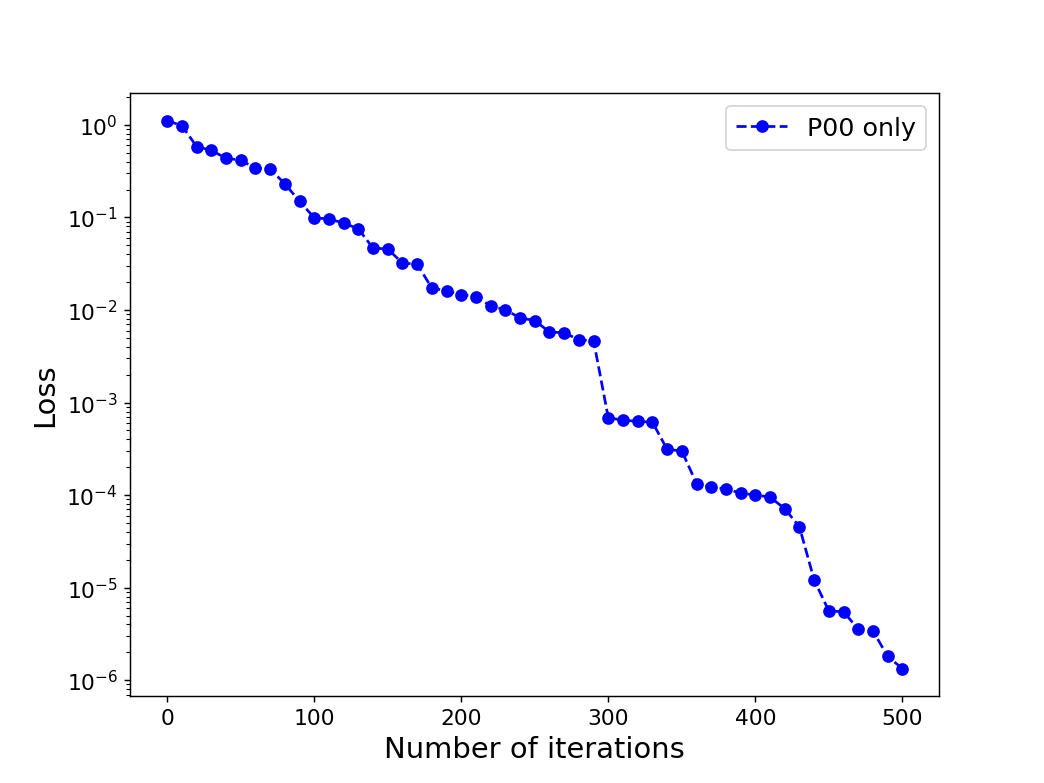

In [30]:
nit1 = 500
nit2 = 300
step = 10

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, nit1+1, step), loss_history[:int(nit1/step)+1], 'bo--', label='P00 only')
# plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit2/step)+1:], 'ro--', label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2 + 1, step), loss_history, 'ro--', label='All coeffs')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

<IPython.core.display.Javascript object>


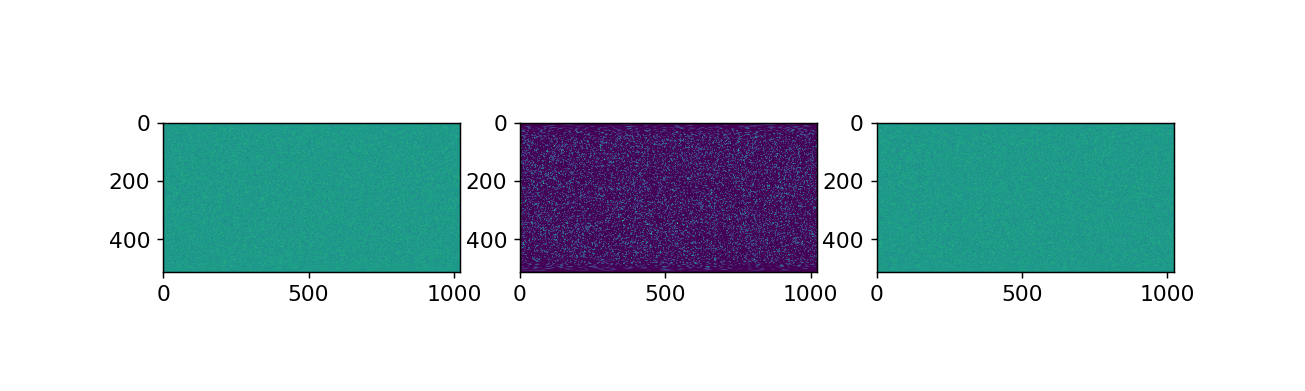

In [31]:
mn, mx = np.nanmin(f_target), np.nanmax(f_target)
#mn, mx = -1, 3
#mn, mx = None, None

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(np.real(f_start), vmax=1, vmin=0, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

In [32]:
#plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

<IPython.core.display.Javascript object>


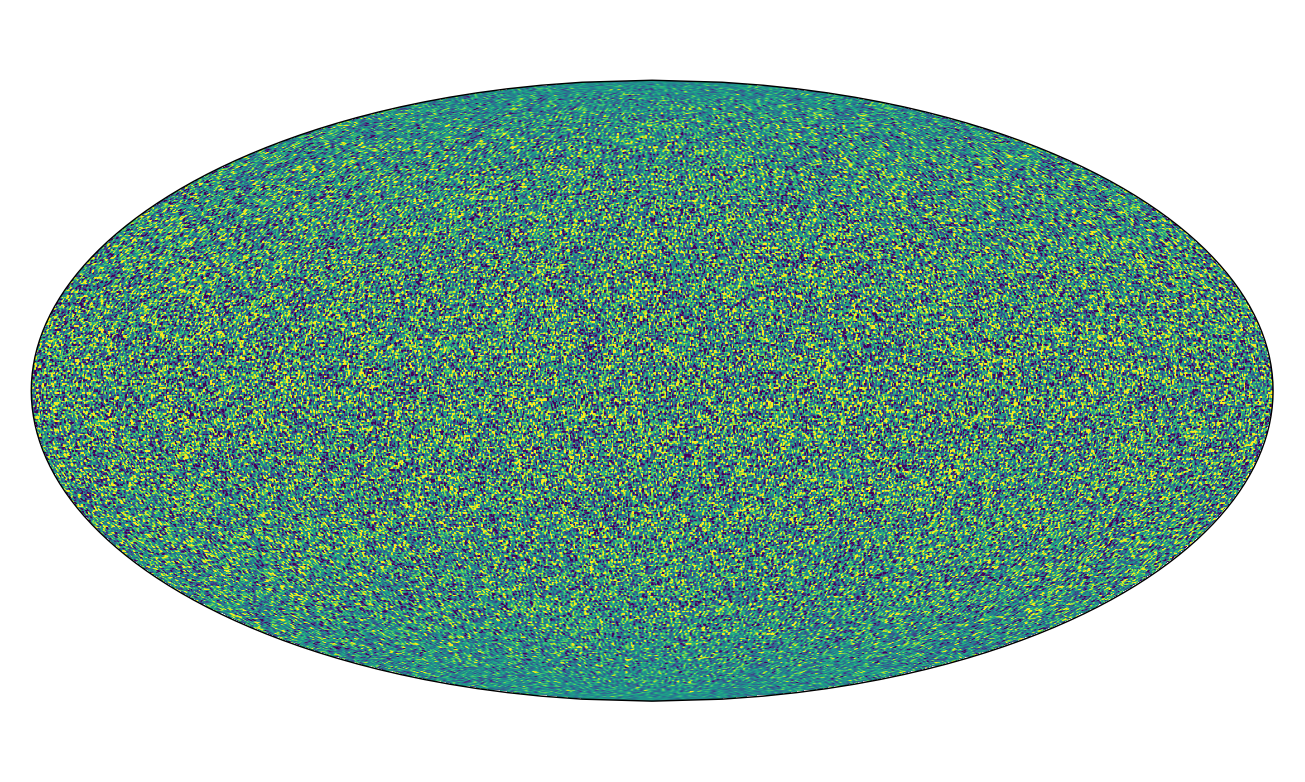

In [38]:
plot.plot_map_MW_Mollweide(f_end, vmin=-1, vmax=1, title='', figsize=(10, 6))#f'End - {mn=:.2f}, {mx=:.2f}', )

### Power spectrum

<IPython.core.display.Javascript object>


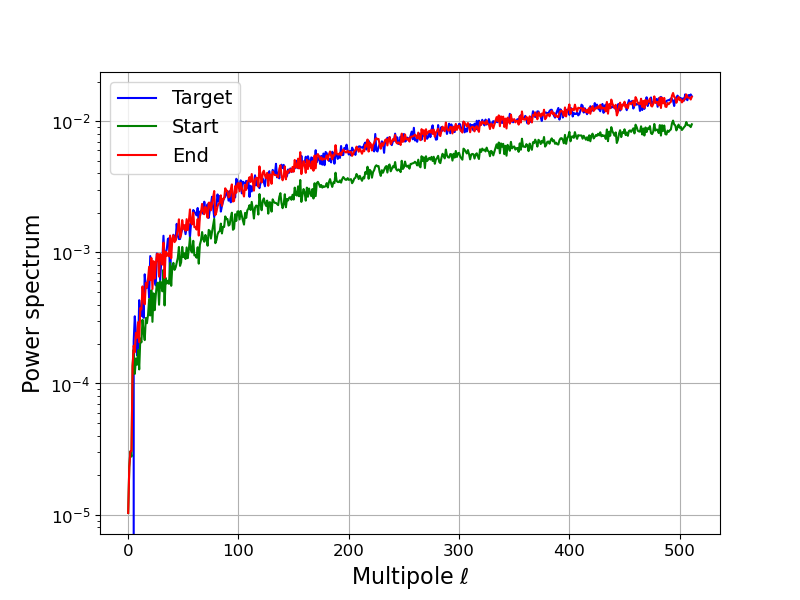

In [39]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
#plt.ylim(1e-4, 1)
plt.legend()

### Plot the coefficients

<IPython.core.display.Javascript object>


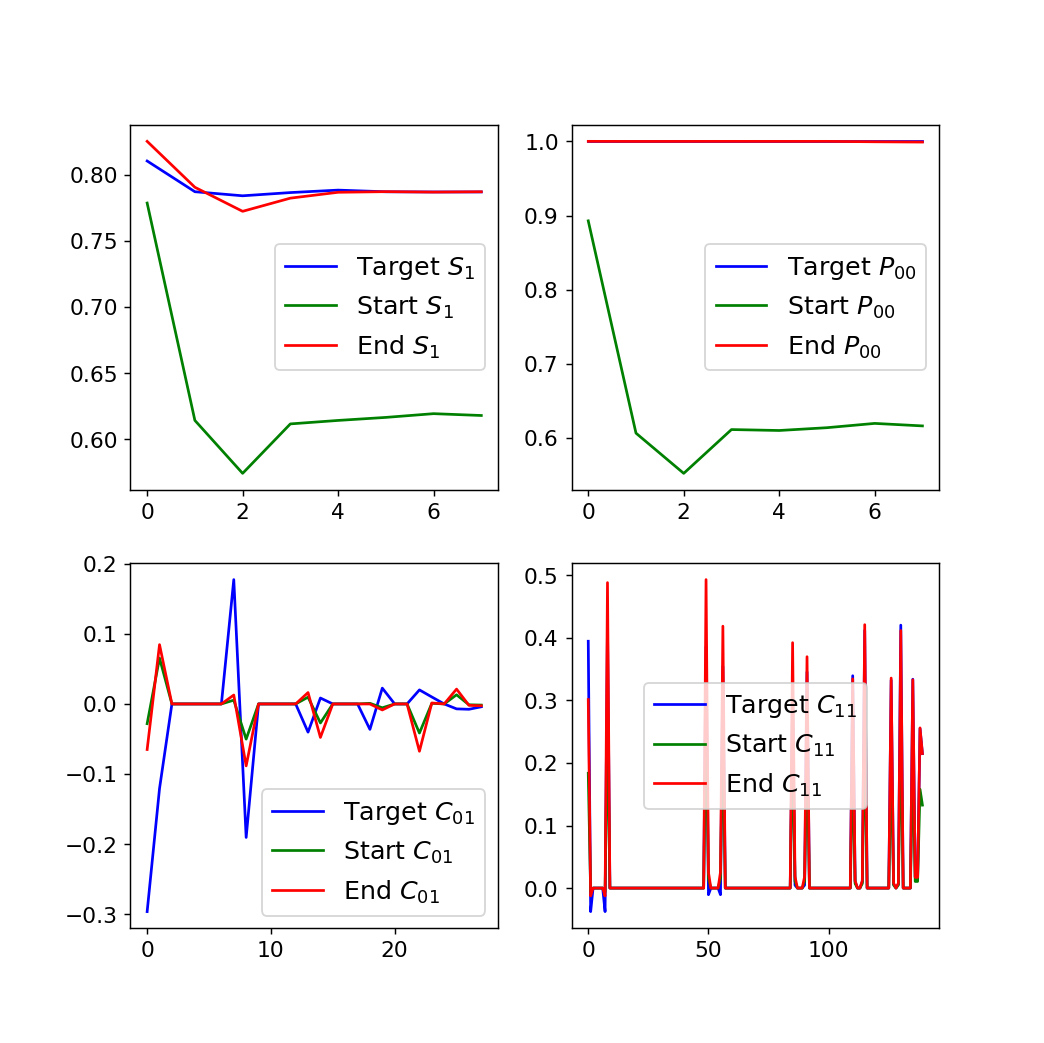

In [35]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')

In [36]:
filters.shape

(10, 512, 1023)

In [37]:
norme_L2 = []
for j in range(J):
    norme_L2.append(np.sum(np.abs(filters[j, :, :])**2))
print(norme_L2)

norme_L2 = np.array(norme_L2)

[0.03799544386587666, 0.10344726053096423, 0.37515651890386714, 1.4250689087678299, 5.550314433552839, 21.901243756449432, 87.00494071919096, 346.81969432385415]


<IPython.core.display.Javascript object>


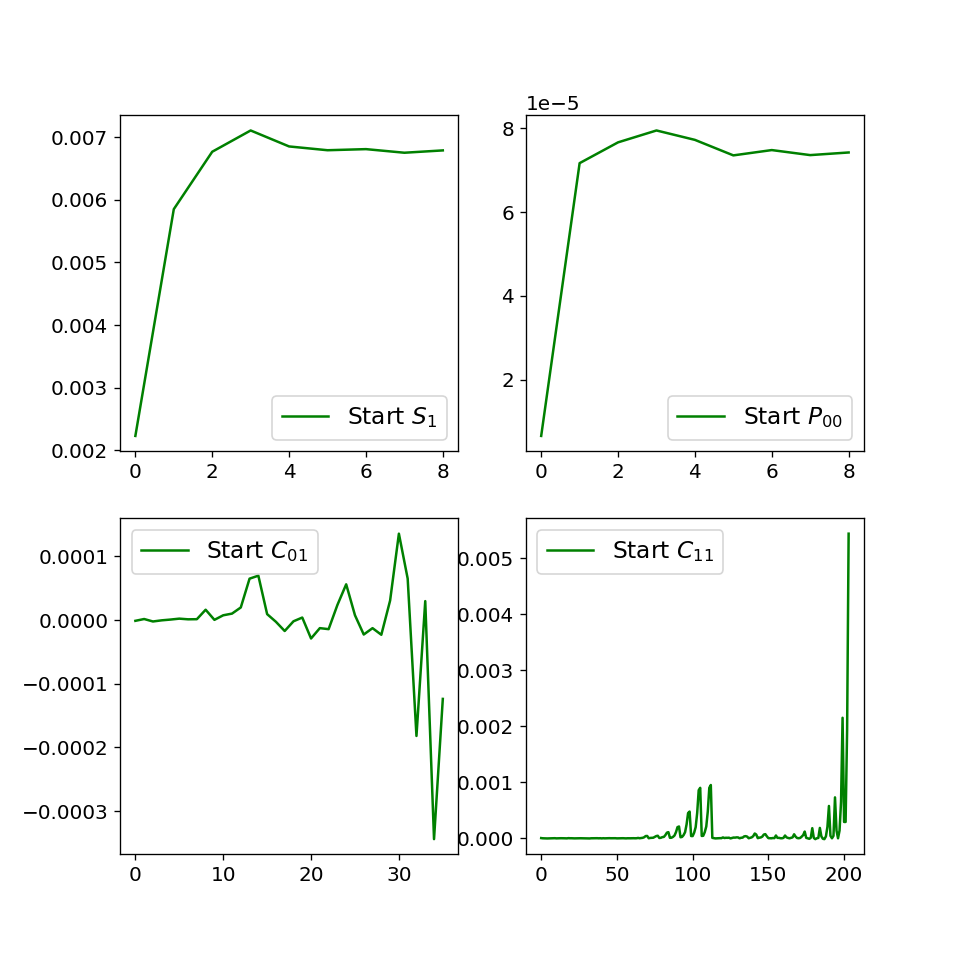

In [36]:
plot.plot_scatcov_coeffs(sS1/np.sqrt(norme_L2), sP00/norme_L2, sC01, sC11, name='Start', hold=True, color='green')

In [98]:
np.sum(sP00)

Array(0.09885659, dtype=float64)